# Stock Market Volatility Prediction using Sentiment Analysis

Overview:
This script predicts next-day stock volatility using:
- Historical OHLCV stock data (via yfinance)
- News headlines with sentiment analysis (FinBERT)
- Technical indicators (RSI, MACD, EMA)
- Time-series models (ARIMA, LSTM)

In [33]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Date and time handling
from datetime import datetime, timedelta
import yfinance as yf

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set display options for better data viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# File handling and web requests
import requests
import os
from pathlib import Path

In [34]:

# Stock selection 
STOCK_TICKER = "AAPL" 
PERIOD = "2y" 
INTERVAL = "1d"  


NEWS_API_KEY = "8f160b733e194588a433aa97baafa4fa"  
COMPANY_NAME = "Apple" 

DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"

# Create directories
for dir_path in [DATA_DIR, RAW_DATA_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

In [35]:

print("COLLECTING STOCK PRICE DATA")
print("="*50)

def collect_stock_data(ticker, period="2y", interval="1d"):
    """
    Collect stock price data using yfinance
    
    Parameters:
    -----------
    ticker : str
        Stock ticker symbol (e.g., 'AAPL', 'TSLA')
    period : str
        Data period ('1y', '2y', '5y', etc.)
    interval : str
        Data interval ('1d', '1h', etc.)
    
    Returns:
    --------
    pandas.DataFrame
        Stock price data with OHLCV columns
    """
    try:
        print(f"🔄 Fetching {ticker} data for period: {period}")
        
        stock = yf.Ticker(ticker)
        df = stock.history(period=period, interval=interval)
        
        df = df.reset_index()
        
        df.columns = [col.replace(' ', '_').lower() for col in df.columns]
        
        df['ticker'] = ticker
        
        print(f"Successfully collected {len(df)} days of data")
        print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
        
        return df
        
    except Exception as e:
        print(f" Error collecting data for {ticker}: {str(e)}")
        return None

# Collect the stock data
df_stock = collect_stock_data(STOCK_TICKER, PERIOD, INTERVAL)



COLLECTING STOCK PRICE DATA
🔄 Fetching AAPL data for period: 2y
Successfully collected 501 days of data
Date range: 2023-06-09 to 2025-06-09


In [36]:
# Display basic information about the collected data
if df_stock is not None:
    print(f"\nStock Data Shape: {df_stock.shape}")
    print(f"Columns: {list(df_stock.columns)}")
    
    # Display first few rows
    print("\nFirst 5 rows of stock data:")
    print(df_stock.head())
    
    # Display last few rows
    print("\nLast 5 rows of stock data:")
    print(df_stock.tail())
    
    # Basic statistics
    print("\n Stock Price Statistics:")
    print(df_stock[['open', 'high', 'low', 'close', 'volume']].describe())


Stock Data Shape: (501, 9)
Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits', 'ticker']

First 5 rows of stock data:
                       date        open        high         low       close    volume  dividends  stock_splits ticker
0 2023-06-09 00:00:00-04:00  179.700793  180.423553  178.839422  179.166153  48870700        0.0           0.0   AAPL
1 2023-06-12 00:00:00-04:00  179.473040  182.067063  179.176011  181.968048  54274900        0.0           0.0   AAPL
2 2023-06-13 00:00:00-04:00  180.987889  182.324498  180.631458  181.492828  54929100        0.0           0.0   AAPL
3 2023-06-14 00:00:00-04:00  181.552258  182.562151  180.215650  182.126511  57462900        0.0           0.0   AAPL
4 2023-06-15 00:00:00-04:00  182.136410  184.671031  181.958187  184.166077  65433200        0.0           0.0   AAPL

Last 5 rows of stock data:
                         date        open        high         low       close    volume  dividends  stock_sp

News Headline Data Collection

In [38]:
print("\n" + "="*50)
print("COLLECTING NEWS HEADLINES FROM NEWSAPI")
print("="*50)

import requests
from datetime import timedelta
import time

def collect_news_data(api_key, start_date, end_date, query="AAPL", sleep_time=1):
    """
    Collect daily financial news headlines using NewsAPI

    Parameters:
    -----------
    api_key : str
        Your NewsAPI key
    start_date : datetime.date
        Start of the date range
    end_date : datetime.date
        End of the date range
    query : str
        Search query (company name, stock symbol, etc.)
    sleep_time : int
        Time delay between API calls (seconds)

    Returns:
    --------
    pandas.DataFrame
        DataFrame with Date and all_headlines columns
    """
    print(f"🔄 Fetching headlines from {start_date} to {end_date} for query: {query}")

    url = "https://newsapi.org/v2/everything"
    headers = {"Authorization": api_key}

    results = []

    current_date = start_date
    while current_date <= end_date:
        from_str = current_date.strftime('%Y-%m-%d')
        to_str = (current_date + timedelta(days=1)).strftime('%Y-%m-%d')

        params = {
            "q": query,
            "from": from_str,
            "to": to_str,
            "language": "en",
            "sortBy": "relevancy",
            "pageSize": 100,
            "apiKey": api_key
        }

        try:
            response = requests.get(url, params=params)
            data = response.json()
            if "articles" in data:
                headlines = [
                    a.get("title", "") + ". " + (a.get("description") or "")
                    for a in data["articles"]
                ]
                full_text = " ".join(headlines)
                results.append({"date": current_date, "all_headlines": full_text})
                print(f"✅ {from_str} | {len(headlines)} articles")
            else:
                print(f"⚠️ {from_str} | No articles found or error: {data.get('message')}")
                results.append({"date": current_date, "all_headlines": ""})

        except Exception as e:
            print(f"❌ Error on {from_str}: {e}")
            results.append({"date": current_date, "all_headlines": ""})

        time.sleep(sleep_time)
        current_date += timedelta(days=1)

    df_news = pd.DataFrame(results)
    return df_news



COLLECTING NEWS HEADLINES FROM NEWSAPI


In [12]:
STOCK_TICKER = "AAPL"
PERIOD = "2y"
INTERVAL = "1d"
NEWSAPI_KEY = "8f160b733e194588a433aa97baafa4fa"  # Replace with your real key
NEWS_QUERY = "Apple OR AAPL"

# Step 1: Get stock data
df_stock = collect_stock_data(STOCK_TICKER, PERIOD, INTERVAL)

# Step 2: Get safe date range for NewsAPI
today = datetime.today().date()
newsapi_earliest = today - timedelta(days=30)

start_date = max(df_stock['date'].min().date(), newsapi_earliest)
end_date = df_stock['date'].max().date()

print(f"\n📅 NewsAPI Date Range Adjusted to: {start_date} → {end_date} (limited to past 30 days)")

# Step 3: Get news headlines
df_news = collect_news_data(NEWSAPI_KEY, start_date, end_date, query=NEWS_QUERY)

🔄 Fetching AAPL data for period: 2y
Successfully collected 501 days of data
Date range: 2023-06-09 to 2025-06-09

📅 NewsAPI Date Range Adjusted to: 2025-05-10 → 2025-06-09 (limited to past 30 days)
🔄 Fetching headlines from 2025-05-10 to 2025-06-09 for query: Apple OR AAPL
✅ 2025-05-10 | 100 articles
✅ 2025-05-11 | 100 articles
✅ 2025-05-12 | 100 articles
✅ 2025-05-13 | 100 articles
✅ 2025-05-14 | 100 articles
✅ 2025-05-15 | 100 articles
✅ 2025-05-16 | 100 articles
✅ 2025-05-17 | 100 articles
✅ 2025-05-18 | 100 articles
✅ 2025-05-19 | 100 articles
✅ 2025-05-20 | 100 articles
✅ 2025-05-21 | 100 articles
✅ 2025-05-22 | 100 articles
✅ 2025-05-23 | 100 articles
✅ 2025-05-24 | 100 articles
✅ 2025-05-25 | 100 articles
✅ 2025-05-26 | 100 articles
✅ 2025-05-27 | 100 articles
✅ 2025-05-28 | 100 articles
✅ 2025-05-29 | 100 articles
✅ 2025-05-30 | 100 articles
✅ 2025-05-31 | 100 articles
✅ 2025-06-01 | 100 articles
✅ 2025-06-02 | 100 articles
✅ 2025-06-03 | 100 articles
✅ 2025-06-04 | 100 article

In [16]:

# Ensure all_headlines is treated as string
df_news['all_headlines'] = df_news['all_headlines'].astype(str)

# Clean: remove duplicates and junk
df_news['all_headlines'] = df_news['all_headlines'].str.lower()
df_news['all_headlines'] = df_news['all_headlines'].str.replace(r'[^\w\s]', '', regex=True)
df_news['all_headlines'] = df_news['all_headlines'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Drop duplicate headlines by date + text
df_news = df_news.drop_duplicates('all_headlines')

# Preview cleaned news
print(df_news[['date', 'all_headlines']])


          date                                      all_headlines
0   2025-05-10  apple may release a mostly glass curved iphone...
1   2025-05-11  apple may release a mostly glass curved iphone...
2   2025-05-12  how to use apple maps on the web apples mappin...
3   2025-05-13  how to use apple maps on the web apples mappin...
4   2025-05-14  trump wants apple to stop making more iphones ...
5   2025-05-15  fortnite for ios is unavailable worldwide fort...
6   2025-05-16  epic asks judge to make apple let fortnite bac...
7   2025-05-17  epic asks judge to make apple let fortnite bac...
8   2025-05-18  apple is trying to get llm siri back on track ...
9   2025-05-19  google starts beta testing android 16s youthfu...
10  2025-05-20  openais big bet that jony ive can make ai hard...
11  2025-05-21  openais big bet that jony ive can make ai hard...
12  2025-05-22  trump threatens apple with a 25 percent iphone...
13  2025-05-23  trump threatens apple with a 25 percent iphone...
14  2025-0

In [87]:
print(df_news.columns)

Index(['date', 'all_headlines', 'sentiment_score'], dtype='object')


In [88]:
from ta.trend import EMAIndicator, MACD
from ta.momentum import RSIIndicator

print("\n" + "=" * 50)
print("📊 MERGING NEWS + STOCK + ENGINEERING FEATURES")
print("=" * 50)
# Normalize both dates to remove timezone and time components
df_stock['date'] = pd.to_datetime(df_stock['date']).dt.tz_localize(None).dt.normalize()
df_news['date'] = pd.to_datetime(df_news['date']).dt.normalize()

# Merge on cleaned 'date'
df_merged = pd.merge(df_stock, df_news, on="date", how="left")

# Fill missing headlines with empty string
df_merged['all_headlines'] = df_merged['all_headlines'].fillna("")


# ---- Step 2: Add technical indicators ----

# EMA (Exponential Moving Average)
ema_10 = EMAIndicator(close=df_merged['close'], window=10)
df_merged['ema_10'] = ema_10.ema_indicator()

# MACD (Moving Average Convergence Divergence)
macd = MACD(close=df_merged['close'])
df_merged['macd'] = macd.macd()
df_merged['macd_signal'] = macd.macd_signal()

# RSI (Relative Strength Index)
rsi = RSIIndicator(close=df_merged['close'], window=14)
df_merged['rsi'] = rsi.rsi()

# ---- Step 3: Add Volatility Feature (Target) ----
df_merged['daily_range'] = df_merged['high'] - df_merged['low']
df_merged['volatility_pct'] = (df_merged['daily_range'] / df_merged['open']) * 100

# ---- Preview ----
print("\n✅ Merged and enriched dataset preview:")
print(df_merged[['date', 'close', 'ema_10', 'macd', 'rsi', 'volatility_pct', 'all_headlines']].tail(5))



📊 MERGING NEWS + STOCK + ENGINEERING FEATURES

✅ Merged and enriched dataset preview:
          date       close      ema_10      macd        rsi  volatility_pct                                      all_headlines
496 2025-06-03  203.270004  202.151681 -1.350536  49.177876        1.395579  apple ordered to keep web links in the app sto...
497 2025-06-04  202.820007  202.273195 -1.216186  48.561801        2.040313  apple ordered to keep web links in the app sto...
498 2025-06-05  200.630005  201.974433 -1.271767  45.569809        2.260445  amazon is going all in this playstation vr bun...
499 2025-06-06  203.919998  202.328172 -1.038371  50.503534        1.798027  apple has a huge siri problem that wwdc 2025 p...
500 2025-06-09  204.835007  202.783960 -0.770685  51.811784        0.988309                                                   


In [89]:
from textblob import TextBlob

# Define scoring function
def get_textblob_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    return TextBlob(text).sentiment.polarity

# Apply sentiment scoring directly to the merged DataFrame
df_merged['sentiment_score'] = df_merged['all_headlines'].apply(get_textblob_sentiment)

# ---- Preview with sentiment ----
print("\n✅ Final dataset preview with sentiment:")
print(df_merged[['date', 'close', 'volatility_pct', 'sentiment_score', 'all_headlines']].tail(5))



✅ Final dataset preview with sentiment:
          date       close  volatility_pct  sentiment_score                                      all_headlines
496 2025-06-03  203.270004        1.395579         0.139492  apple ordered to keep web links in the app sto...
497 2025-06-04  202.820007        2.040313         0.140479  apple ordered to keep web links in the app sto...
498 2025-06-05  200.630005        2.260445         0.153507  amazon is going all in this playstation vr bun...
499 2025-06-06  203.919998        1.798027         0.164520  apple has a huge siri problem that wwdc 2025 p...
500 2025-06-09  204.835007        0.988309         0.000000                                                   


In [90]:
df_merged.to_csv("merged_stock_news_and_score.csv", index=False)

📈 Volatility Over Time

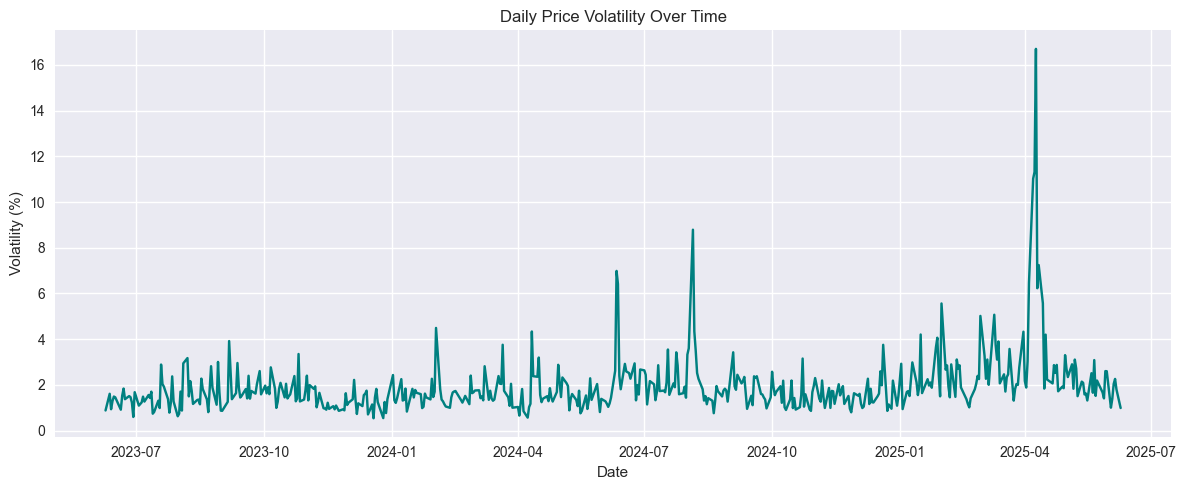

In [91]:
plt.figure(figsize=(12, 5))
plt.plot(df_merged['date'], df_merged['volatility_pct'], color='teal')
plt.title('Daily Price Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


Volitality: Frequency distribution of daily price swings

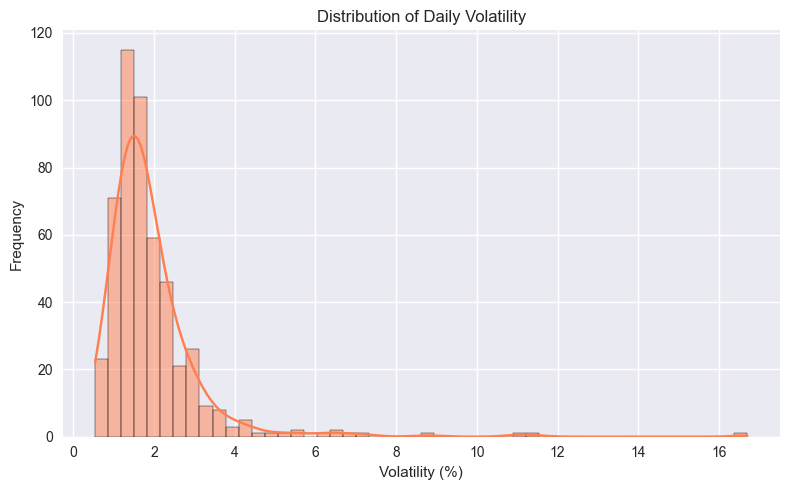

In [92]:
plt.figure(figsize=(8, 5))
sns.histplot(df_merged['volatility_pct'], bins=50, kde=True, color='coral')
plt.title('Distribution of Daily Volatility')
plt.xlabel('Volatility (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [93]:
#corrections 
df_merged['rsi_lag1'] = df_merged['rsi'].shift(1)


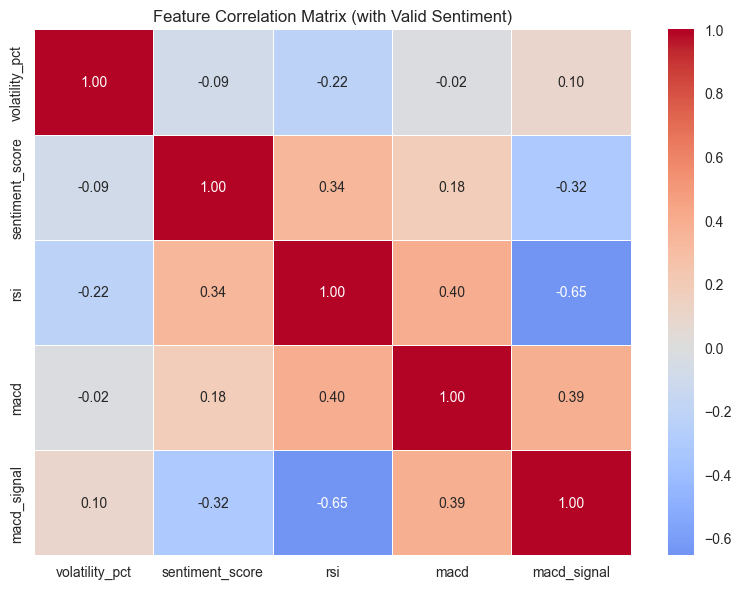

In [94]:

# Define relevant features
features = ['volatility_pct', 'sentiment_score', 'rsi', 'macd', 'macd_signal']

# Filter to rows where sentiment score is non-zero (or non-null)
df_corr_filtered = df_merged[df_merged['sentiment_score'] != 0.0][features].dropna()

# Compute correlation matrix
corr_matrix = df_corr_filtered.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix (with Valid Sentiment)')
plt.tight_layout()
plt.show()


Baseline check - phase 1

In [95]:
print(df_merged.columns)

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits', 'ticker', 'all_headlines', 'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range', 'volatility_pct', 'rsi_lag1'], dtype='object')


In [120]:

# RSI signal: crossing above/below a threshold (example logic — customize as needed)
df_merged['rsi_signal'] = df_merged['rsi'].apply(lambda x: 1 if x > 70 else (-1 if x < 30 else 0))


📉 Linear Regression Baseline with Lagged Volatility:
RMSE: 0.3485
MAE: 0.1351
R² Score: 0.9791


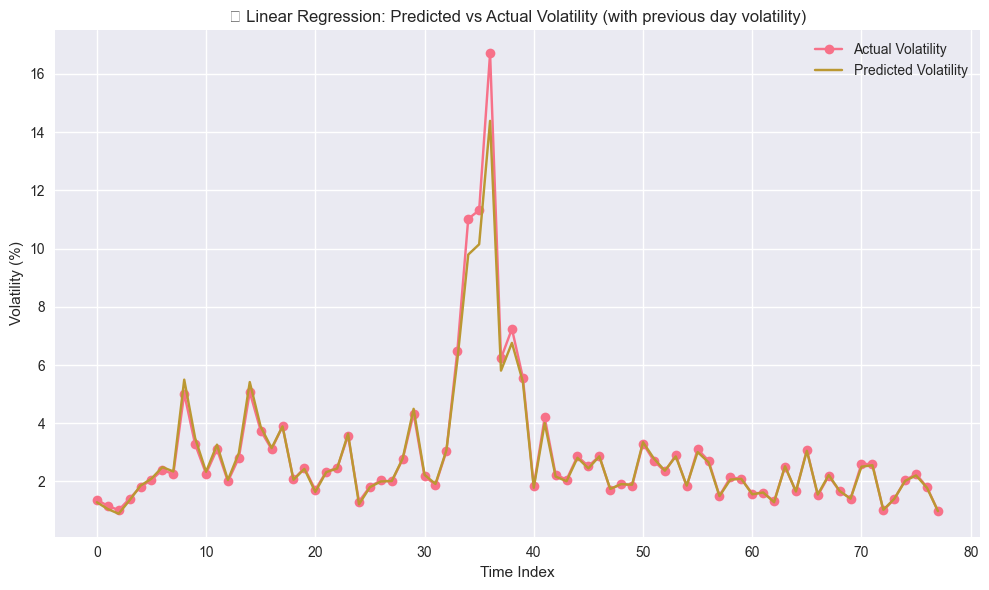

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Create lagged volatility feature ---
df_merged['volatility_pct_lag1'] = df_merged['volatility_pct'].shift(1)


# --- Define your modeling DataFrame with lagged volatility included ---
df_model = df_merged[[
    'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
    'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range',
    'volatility_pct',  # target
    'rsi_lag1', 
    'rsi_signal',
    'volatility_pct_lag1'  # new lag feature
]].dropna()

# --- Define features and target ---
# Exclude 'volatility_pct' (target) from features
features = [
    'open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
    'sentiment_score', 'ema_10', 'macd', 'macd_signal', 'rsi', 'daily_range',
    'rsi_lag1', 
    'rsi_signal',
    'volatility_pct_lag1'  # include previous day volatility
]

X = df_model[features]
y = df_model['volatility_pct']

# --- TimeSeriesSplit for train/test ---
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# --- Fit Linear Regression ---
lr = LinearRegression()
lr.fit(X_train, y_train)

# --- Predict and evaluate ---
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📉 Linear Regression Baseline with Lagged Volatility:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Volatility', marker='o')
plt.plot(y_pred, label='Predicted Volatility', marker='x')
plt.title('📊 Linear Regression: Predicted vs Actual Volatility (with previous day volatility)')
plt.xlabel('Time Index')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [122]:
# Get coefficients and feature names
coef = lr.coef_
features = X.columns

# Create DataFrame for easier viewing
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'AbsCoefficient': np.abs(coef)
})

# Sort by absolute coefficient value descending
coef_df_sorted = coef_df.sort_values(by='AbsCoefficient', ascending=False).reset_index(drop=True)

print("📋 Linear Regression Feature Coefficients (sorted by importance):")
print(coef_df_sorted[['Feature', 'Coefficient']])


📋 Linear Regression Feature Coefficients (sorted by importance):
                Feature   Coefficient
0           daily_range  3.203773e-01
1                  high  1.645570e-01
2                   low -1.558202e-01
3             dividends  2.892386e-02
4                  open -2.766248e-02
5                  macd  2.249406e-02
6           macd_signal -1.697801e-02
7                 close  6.699150e-03
8                ema_10  3.810706e-03
9                   rsi -3.260246e-03
10  volatility_pct_lag1  2.211450e-03
11             rsi_lag1  2.132143e-03
12           rsi_signal  4.861124e-04
13               volume  1.594828e-10
14      sentiment_score -5.551115e-17
15         stock_splits -4.770490e-18
